# Steady One-Dimensional Counterflow Laminar Diffusion Flames: Extinction

This Jupyter Notebook was written by Dan Haworth. It is intended as a tutorial to be used in parallel with Chapter 9 of the book "An Introduction to Combustion: Concepts and Applications" by Stephen R. Turns and Daniel C. Haworth. That book is referred to as "Turns 4th ed." throughout this Notebook.

This Notebook was last updated 20 February 2020.

The objective of this tutorial is to expand on the discussion of the influence of strain rate on laminar diffusion flame structure: specifically, to extend that to strain rates that are high enough to result in extinction. The influence of the choice of initial conditions on the computed extinction strain rate is demonstrated and discussed. We will use the thermodynamic properties, reaction mechanism, and molecular transport properties that are included in gri30.cti.

The reader should be familiar with the material in the previous tutorial Notebook (9_1_Counterflow_laminar_diffusion_flame) before working through this Notebook.

## 1. Strain-rate-induced extinction

As discussed in the previous tutorial Notebook (9_1_Counterflow_laminar_diffusion_flame), the structure of a constant-pressure adiabatic counterflow laminar diffusion flame varies strongly with the hydrodynamic strain rate to which the flame is subjected. The lower the strain rate, the broader the temperature and species profiles are in physical space, and the closer the peak temperature is to the constant-pressure adiabatic flame temperature. As the strain rate increases, the profiles narrow, so that spatial gradients are steeper and molecular transport becomes increasingly important. At some point, the finite-rate chemical reactions cannot keep up with the high transport rates of enthalpy and species away from the flame, and the flame extinguishes. The strain rate at which extinction occurs is very sensitive to chemical reaction rates and molecular transport properties. For that reason, comparisons between computed and measured extinction strain rates in counterflow laminar diffusion flames are often used to validate reaction mechanisms and transport property formulations.

In numerical simulations, various kinds of numerical inaccuracies occur that result in the numerical solution to the governing equations being different from the exact solution. Numerical inaccuracies are particularly important when trying to capture threshold phenomona, such as the strain rate at which a counterflow laminar diffusion flame extinguishes. The influence of the assumed initial conditions on the computed extinction strain rate is explored in Section 3 below.

## 2. A basic extinction-strain-rate calculation

We begin by repeating the C2H6-air flame calculations from the previous tutorial Notebook, and extending those to higher strain rates. The maximum temperature is monitored, to distinguish a burning case from a nonburning (extinguished) case.

In [1]:
# import modules
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import time

# print Cantera version
print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.4.0


In [2]:
# define the gas mixture
gas = ct.Solution('gri30.cti')

# specify the pressure (constant and uniform) and the fuel and oxidizer boundary conditions
# the fuel and oxidizer mass flow rates are set here to base values that correspond to a low strain rate
# then the base mass flow rates will be multiplied by different constant values to simulate flames with progressively
#   higher strain-rate values
P = ct.one_atm  # (Pa)

# fuel nozzle
T_fuel         = 300.0              # (K)
X_fuel         = 'C2H6:1'           # mole fractions
mdot_fuel_base = 0.010              # (kg/m^2-s)

# oxidizer nozzle
T_oxid         = 300.0              # (K)
X_oxid         = 'O2:0.21, N2:0.79' # mole fractions
mdot_oxid_base = 0.030              # (kg/m^2-s)

# distance between the fuel and oxidizer nozzles
width = 0.02 # (m)

# create the flame object
flame = ct.CounterflowDiffusionFlame(gas, width=width)

# disable radiative heat transfer
flame.set_boundary_emissivities(0.0, 0.0)
flame.radiation_enabled = False

# specify grid-refinement parameters
flame.set_refine_criteria(ratio=4, slope=0.2, curve=0.3, prune=0.04)

# specify level of output desired
loglevel = 0

# specify the fuel and oxidizer nozzle mixture temperatures and compositions
# these are the same for all cases
flame.fuel_inlet.T     = T_fuel
flame.fuel_inlet.X     = X_fuel
    
flame.oxidizer_inlet.T = T_oxid
flame.oxidizer_inlet.X = X_oxid

In [3]:
# specify the reactant-mass-flow-rate multipliers
mmults = [1., 10., 50., 100., 1000.]

# define arrays to store values of various quantities for different strain rates
a_stoich = np.zeros(len(mmults))
T_max    = np.zeros(len(mmults))
NO_max   = np.zeros(len(mmults))

 
Solution for strain rate 19.17/s required 8.63 s. Max temperature is 2098.05 K
 
Solution for strain rate 139.04/s required 15.06 s. Max temperature is 2023.93 K
 
Solution for strain rate 560.47/s required 17.28 s. Max temperature is 1935.48 K
 
Solution for strain rate 1015.42/s required 22.85 s. Max temperature is 1882.36 K
 
Solution for strain rate 3280.14/s required 13.12 s. Max temperature is 300.00 K


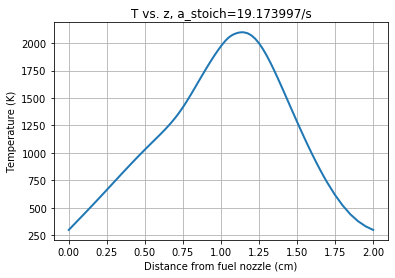

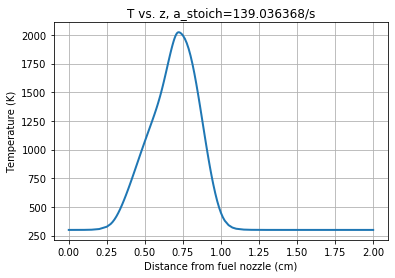

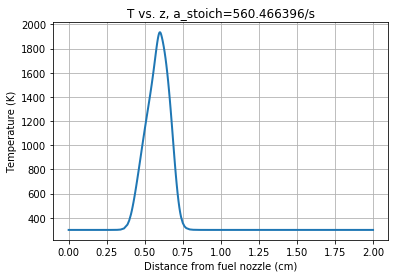

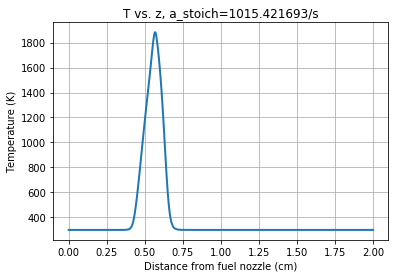

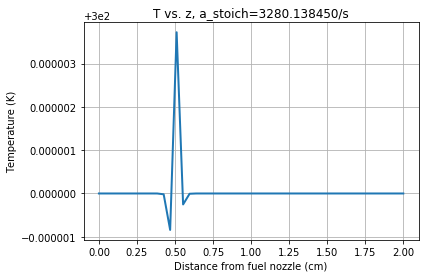

In [4]:
# loop over the reactant-mass-flow-rate multipliers
# the flame is reinitialized to the original six-point grid for each case
for i , mult in enumerate(mmults):
    mdot_fuel = mult*mdot_fuel_base
    mdot_oxid = mult*mdot_oxid_base

# re-initialize the flame
    gas.TPX = 300., P, 'C2H6:1.'
    flame = ct.CounterflowDiffusionFlame(gas, width=width)
    flame.set_boundary_emissivities(0.0, 0.0)
    flame.radiation_enabled = False
    flame.set_refine_criteria(ratio=4, slope=0.2, curve=0.3, prune=0.04)
    flame.fuel_inlet.T     = T_fuel
    flame.fuel_inlet.X     = X_fuel   
    flame.oxidizer_inlet.T = T_oxid
    flame.oxidizer_inlet.X = X_oxid

# reset the fuel and oxidizer mass flow rates
    flame.fuel_inlet.mdot     = mdot_fuel
    flame.oxidizer_inlet.mdot = mdot_oxid

# compute the steady-state solution, and track the computational time
    ctim0 = time.time()
    flame.solve(loglevel=loglevel, auto=True)
    ctim1 = time.time()
    ctime = ctim1 - ctim0

# store the strain rate, peak temperature, and peak NO mole fraction
    a_stoich[i] = flame.strain_rate('stoichiometric', fuel='C2H6', oxidizer='O2')
    T_max[i]    = np.max(flame.T)
    NO_max[i]   = np.max(flame.X[gas.species_index('NO')])

# plot the steady-state temperature profile
    fig, ax = plt.subplots()
    ax.plot(flame.grid*100., flame.T, '-', label='T', lw=2)
    ptitle  = "T vs. z, a_stoich={:2f}/s".format(a_stoich[i])
    ax.set(xlabel='Distance from fuel nozzle (cm)',
           ylabel='Temperature (K)',
           title = ptitle)
    ax.grid(True)
#    ax.legend(handlelength=4,loc='best')

# print the strain rate (at the stoichiometric location), the computational time required, and the maximum temperature
    print(" ")
    print("Solution for strain rate {:.2f}/s required {:.2f} s. Max temperature is {:.2f} K".format(a_stoich[i],
                                                                                                    ctime,T_max[i]))

For the highest fuel and oxidizer mass flow rates (the highest strain rate), the temperature profile is essentially uniform at 300 K, the temperature of the fuel jet and of the oxidizer jet: the flame has extinguished. This suggests that extinction occurs for a value of the strain rate that is between approximately 1000/s and 3300/s.

To home in on the strain rate at which extinction occurs, we can proceed as follows:

In [5]:
# specify the reactant-mass-flow-rate multipliers
mmults = [100., 150., 200.]

# define arrays to store values of various quantitites for different strain rates
a_stoich = np.zeros(len(mmults))
T_max    = np.zeros(len(mmults))
NO_max   = np.zeros(len(mmults))

 
Solution for strain rate 1015.42/s required 22.26 s. Max temperature is 1882.36 K
 
Solution for strain rate 1423.49/s required 19.02 s. Max temperature is 1843.26 K
 
Solution for strain rate 653.78/s required 38.51 s. Max temperature is 300.00 K


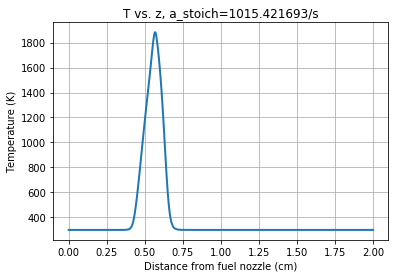

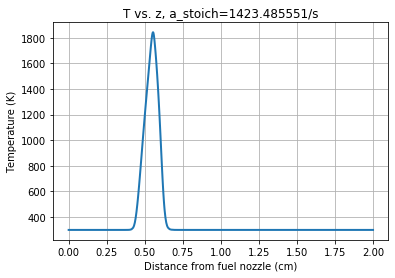

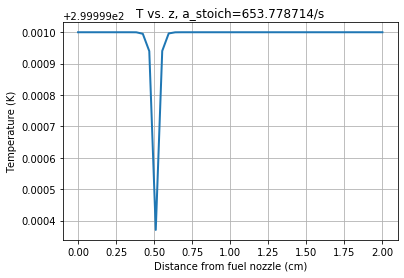

In [6]:
# loop over the reactant-mass-flow-rate multipliers
# the flame is reinitialized to the original six-point grid for each case
for i , mult in enumerate(mmults):
    mdot_fuel = mult*mdot_fuel_base
    mdot_oxid = mult*mdot_oxid_base

# re-initialize the flame
    gas.TPX = 300., P, 'C2H6:1.'
    flame = ct.CounterflowDiffusionFlame(gas, width=width)
    flame.set_boundary_emissivities(0.0, 0.0)
    flame.radiation_enabled = False
    flame.set_refine_criteria(ratio=4, slope=0.2, curve=0.3, prune=0.04)
    flame.fuel_inlet.T     = T_fuel
    flame.fuel_inlet.X     = X_fuel   
    flame.oxidizer_inlet.T = T_oxid
    flame.oxidizer_inlet.X = X_oxid

# reset the fuel and oxidizer mass flow rates
    flame.fuel_inlet.mdot     = mdot_fuel
    flame.oxidizer_inlet.mdot = mdot_oxid

# compute the steady-state solution, and track the computational time
    ctim0 = time.time()
    flame.solve(loglevel=loglevel, auto=True)
    ctim1 = time.time()
    ctime = ctim1 - ctim0

# store the strain rate, peak temperature, and peak NO mole fraction
    a_stoich[i] = flame.strain_rate('stoichiometric', fuel='C2H6', oxidizer='O2')
    T_max[i]    = np.max(flame.T)
    NO_max[i]   = np.max(flame.X[gas.species_index('NO')])

# plot the steady-state temperature profile
    fig, ax = plt.subplots()
    ax.plot(flame.grid*100., flame.T, '-', label='T', lw=2)
    ptitle  = "T vs. z, a_stoich={:2f}/s".format(a_stoich[i])
    ax.set(xlabel='Distance from fuel nozzle (cm)',
           ylabel='Temperature (K)',
           title = ptitle)
    ax.grid(True)
#    ax.legend(handlelength=4,loc='best')

# print the strain rate (at the stoichiometric location), the computational time required, and the maximum temperature
    print(" ")
    print("Solution for strain rate {:.2f}/s required {:.2f} s. Max temperature is {:.2f} K".format(a_stoich[i],
                                                                                                    ctime,T_max[i]))

Note that the value of a_stoich is lower for the extinguished case than for the last burning case. That is because the strain rate profile for the extinguished case does not have the intermediate peaks that were seen in the previous tutorial Notebook for burning cases. That can be confirmed by plotting the strain rate profile.

These results suggests that extinction occurs for values of the fuel and oxidizer mass flow rates that are between the last two values simulated. We could continue in this manner to further refine our estimate of the extinction strain rate, but it will be more instructive to consider the influence of the assumed initial conditions as we refine our estimate.

## 3. Influence of initial conditions on the computed extinction strain rate

Note that in the above simulations, we restarted from scratch with a coarse uniform mesh for each new value of the fuel and oxidzer mass flow rates. Alternatively, we could use the converged solution from the previous case as the initial condition, and just update the fuel and oxidizer mass flow rates.

Let's rerun the last three cases using the latter approach:

In [7]:
# specify the reactant-mass-flow-rate multipliers
mmults = [100., 150., 200.]

# define arrays to store values of various quantitites for different strain rates
a_stoich = np.zeros(len(mmults))
T_max    = np.zeros(len(mmults))
NO_max   = np.zeros(len(mmults))

mdot_fuel = mmults[0]*mdot_fuel_base
mdot_oxid = mmults[0]*mdot_oxid_base

# initialize the flame
gas.TPX = 300., P, 'C2H6:1.'
flame = ct.CounterflowDiffusionFlame(gas, width=width)
flame.set_boundary_emissivities(0.0, 0.0)
flame.radiation_enabled = False
flame.set_refine_criteria(ratio=4, slope=0.2, curve=0.3, prune=0.04)
flame.fuel_inlet.T     = T_fuel
flame.fuel_inlet.X     = X_fuel   
flame.oxidizer_inlet.T = T_oxid
flame.oxidizer_inlet.X = X_oxid

 
Solution for strain rate 1015.42/s required 22.03 s. Max temperature is 1882.36 K
 
Solution for strain rate 1429.53/s required 43.16 s. Max temperature is 1843.60 K
 
Solution for strain rate 1817.90/s required 50.16 s. Max temperature is 1808.03 K


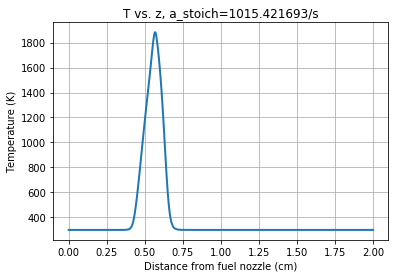

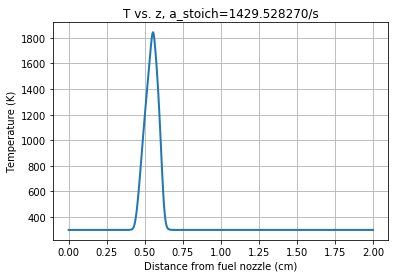

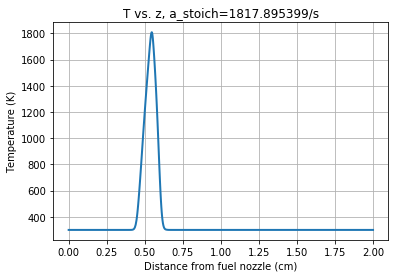

In [8]:
# loop over the reactant-mass-flow-rate multipliers
# here the converged solution from the previous case is taken as the initial condition for the new fuel and oxidizer
#   mass flow rates
for i , mult in enumerate(mmults):
    mdot_fuel = mult*mdot_fuel_base
    mdot_oxid = mult*mdot_oxid_base

# reset the fuel and oxidizer mass flow rates
    flame.fuel_inlet.mdot     = mdot_fuel
    flame.oxidizer_inlet.mdot = mdot_oxid

# compute the steady-state solution, and track the computational time
    ctim0 = time.time()
    flame.solve(loglevel=loglevel, auto=True)
    ctim1 = time.time()
    ctime = ctim1 - ctim0

# store the strain rate, peak temperature, and peak NO mole fraction
    a_stoich[i] = flame.strain_rate('stoichiometric', fuel='C2H6', oxidizer='O2')
    T_max[i]    = np.max(flame.T)
    NO_max[i]   = np.max(flame.X[gas.species_index('NO')])

# plot the steady-state temperature profile
    fig, ax = plt.subplots()
    ax.plot(flame.grid*100., flame.T, '-', label='T', lw=2)
    ptitle  = "T vs. z, a_stoich={:2f}/s".format(a_stoich[i])
    ax.set(xlabel='Distance from fuel nozzle (cm)',
           ylabel='Temperature (K)',
           title = ptitle)
    ax.grid(True)
#    ax.legend(handlelength=4,loc='best')

# print the strain rate (at the stoichiometric location), the computational time required, and the maximum temperature
    print(" ")
    print("Solution for strain rate {:.2f}/s required {:.2f} s. Max temperature is {:.2f} K".format(a_stoich[i],
                                                                                                    ctime,T_max[i]))

This time, a burning solution was found for the highest mass flow rate case. Also, the computational time required for the second and third cases is higher here than for the case where we reinitialized using a coarse uniform mesh, because the number of grid points is higher throughout the course of the solution process here. Presumably, the solution obtained by restarting using an initial condition from a relatively nearby converged solution is more reliable, compared to restarting from scratch.

Now let's see if we can get a better estimate of the extinction strain rate.

In [9]:
# specify the reactant-mass-flow-rate multipliers
mmults = [150., 200., 250., 300., 350.]

# define arrays to store values of various quantitites for different strain rates
a_stoich = np.zeros(len(mmults))
T_max    = np.zeros(len(mmults))
NO_max   = np.zeros(len(mmults))

mdot_fuel = mmults[0]*mdot_fuel_base
mdot_oxid = mmults[0]*mdot_oxid_base

# re-initialize the flame
gas.TPX = 300., P, 'C2H6:1.'
flame = ct.CounterflowDiffusionFlame(gas, width=width)
flame.set_boundary_emissivities(0.0, 0.0)
flame.radiation_enabled = False
flame.set_refine_criteria(ratio=4, slope=0.2, curve=0.3, prune=0.04)
flame.fuel_inlet.T     = T_fuel
flame.fuel_inlet.X     = X_fuel   
flame.oxidizer_inlet.T = T_oxid
flame.oxidizer_inlet.X = X_oxid

 
Solution for strain rate 1423.49/s required 19.12 s. Max temperature is 1843.26 K
 
Solution for strain rate 1815.00/s required 41.31 s. Max temperature is 1806.51 K
 
Solution for strain rate 2155.20/s required 42.25 s. Max temperature is 1758.88 K
 
Solution for strain rate 981.09/s required 100.25 s. Max temperature is 300.00 K
 
Solution for strain rate 1144.85/s required 34.54 s. Max temperature is 300.00 K


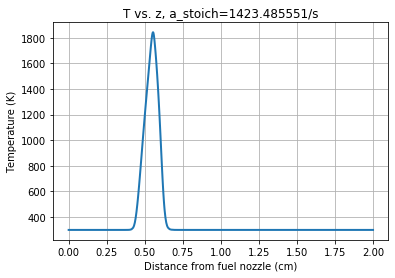

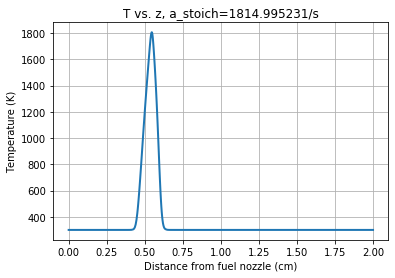

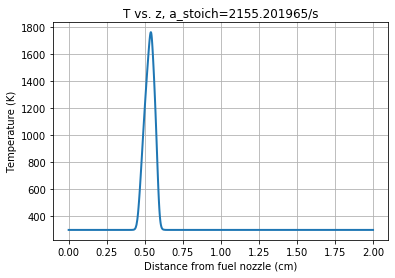

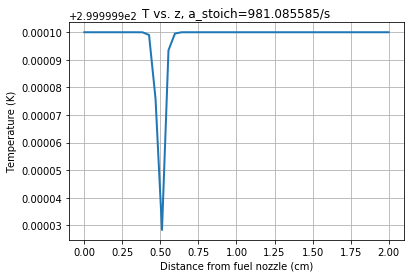

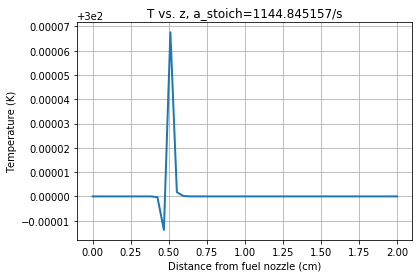

In [10]:
# loop over the reactant-mass-flow-rate multipliers
# here the converged solution from the previous case is taken as the initial condition for the new fuel and oxidizer
#   mass flow rates
for i , mult in enumerate(mmults):
    mdot_fuel = mult*mdot_fuel_base
    mdot_oxid = mult*mdot_oxid_base

# reset the fuel and oxidizer mass flow rates
    flame.fuel_inlet.mdot     = mdot_fuel
    flame.oxidizer_inlet.mdot = mdot_oxid

# compute the steady-state solution, and track the computational time
    ctim0 = time.time()
    flame.solve(loglevel=loglevel, auto=True)
    ctim1 = time.time()
    ctime = ctim1 - ctim0

# store the strain rate, peak temperature, and peak NO mole fraction
    a_stoich[i] = flame.strain_rate('stoichiometric', fuel='C2H6', oxidizer='O2')
    T_max[i]    = np.max(flame.T)
    NO_max[i]   = np.max(flame.X[gas.species_index('NO')])

# plot the steady-state temperature profile
    fig, ax = plt.subplots()
    ax.plot(flame.grid*100., flame.T, '-', label='T', lw=2)
    ptitle  = "T vs. z, a_stoich={:2f}/s".format(a_stoich[i])
    ax.set(xlabel='Distance from fuel nozzle (cm)',
           ylabel='Temperature (K)',
           title = ptitle)
    ax.grid(True)
#    ax.legend(handlelength=4,loc='best')

# print the strain rate (at the stoichiometric location), the computational time required, and the maximum temperature
    print(" ")
    print("Solution for strain rate {:.2f}/s required {:.2f} s. Max temperature is {:.2f} K".format(a_stoich[i],
                                                                                                    ctime,T_max[i]))

This suggests that extinction occurs between the third and fourth cases simulated. 

Let's home in further:

In [11]:
# specify the reactant-mass-flow-rate multipliers
mmults = [150., 200., 250., 260., 270., 280., 290., 300.]

# define arrays to store values of various quantitites for different strain rates
a_stoich = np.zeros(len(mmults))
T_max    = np.zeros(len(mmults))
NO_max   = np.zeros(len(mmults))

mdot_fuel = mmults[0]*mdot_fuel_base
mdot_oxid = mmults[0]*mdot_oxid_base

# re-initialize the flame
gas.TPX = 300., P, 'C2H6:1.'
flame = ct.CounterflowDiffusionFlame(gas, width=width)
flame.set_boundary_emissivities(0.0, 0.0)
flame.radiation_enabled = False
flame.set_refine_criteria(ratio=4, slope=0.2, curve=0.3, prune=0.04)
flame.fuel_inlet.T     = T_fuel
flame.fuel_inlet.X     = X_fuel   
flame.oxidizer_inlet.T = T_oxid
flame.oxidizer_inlet.X = X_oxid

 
Solution for strain rate 1423.49/s required 19.97 s. Max temperature is 1843.26 K
 
Solution for strain rate 1815.00/s required 41.29 s. Max temperature is 1806.51 K
 
Solution for strain rate 2155.20/s required 42.38 s. Max temperature is 1758.88 K
 
Solution for strain rate 2212.92/s required 43.91 s. Max temperature is 1745.28 K
 
Solution for strain rate 2271.60/s required 44.32 s. Max temperature is 1732.83 K
 
Solution for strain rate 2316.49/s required 43.38 s. Max temperature is 1712.17 K
 
Solution for strain rate 948.34/s required 102.41 s. Max temperature is 300.00 K
 
Solution for strain rate 981.09/s required 41.06 s. Max temperature is 300.00 K


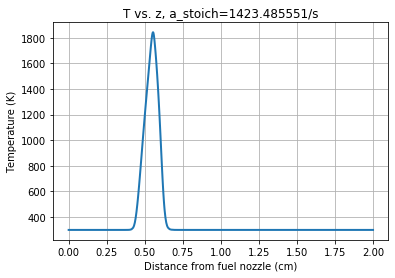

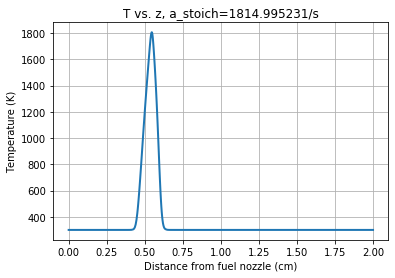

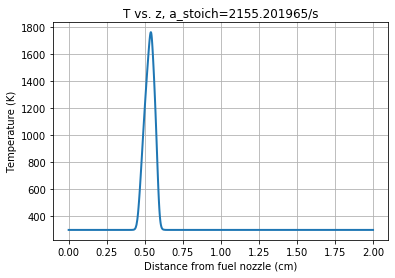

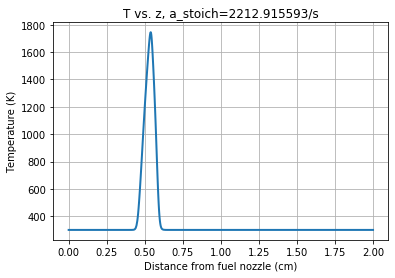

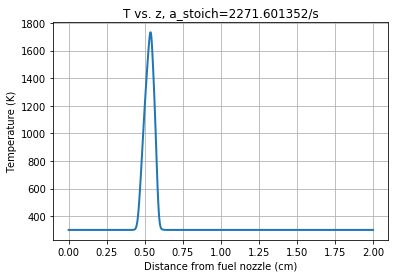

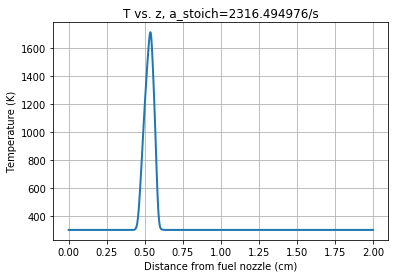

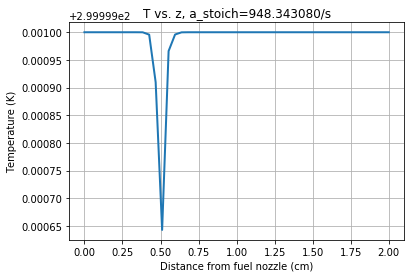

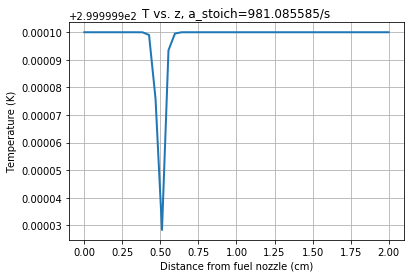

In [12]:
# loop over the reactant-mass-flow-rate multipliers
# here the converged solution from the previous case is taken as the initial condition for the new fuel and oxidizer
#   mass flow rates
for i , mult in enumerate(mmults):
    mdot_fuel = mult*mdot_fuel_base
    mdot_oxid = mult*mdot_oxid_base

# reset the fuel and oxidizer mass flow rates
    flame.fuel_inlet.mdot     = mdot_fuel
    flame.oxidizer_inlet.mdot = mdot_oxid

# compute the steady-state solution, and track the computational time
    ctim0 = time.time()
    flame.solve(loglevel=loglevel, auto=True)
    ctim1 = time.time()
    ctime = ctim1 - ctim0

# store the strain rate, peak temperature, and peak NO mole fraction
    a_stoich[i] = flame.strain_rate('stoichiometric', fuel='C2H6', oxidizer='O2')
    T_max[i]    = np.max(flame.T)
    NO_max[i]   = np.max(flame.X[gas.species_index('NO')])

# plot the steady-state temperature profile
    fig, ax = plt.subplots()
    ax.plot(flame.grid*100., flame.T, '-', label='T', lw=2)
    ptitle  = "T vs. z, a_stoich={:2f}/s".format(a_stoich[i])
    ax.set(xlabel='Distance from fuel nozzle (cm)',
           ylabel='Temperature (K)',
           title = ptitle)
    ax.grid(True)
#    ax.legend(handlelength=4,loc='best')

# print the strain rate (at the stoichiometric location), the computational time required, and the maximum temperature
    print(" ")
    print("Solution for strain rate {:.2f}/s required {:.2f} s. Max temperature is {:.2f} K".format(a_stoich[i],
                                                                                                    ctime,T_max[i]))

From these results, it is estimated that the extinction strain rate (based on the value of the strain rate at the stoichiometric location) is somewhat higher than 2300/s. We could continue in this manner to get a more accurate estimate.

To perform parametric studies of how the extinction strain rate varies with (say) fuel and oxidizer type, fuel and oxidizer temperature, pressure, etc., one could define a function that computes the extinction strain rate directly for a given pressure, given fuel jet temperature, composition, and mass flow rate, and given oxidizer jet temperature, composition, and mass flow rate. That can be done by designing an iterative method that systematically increases the strain rate until extinction is observed, in a manner that mimics the manual process that was used above. 

An appropriate approach can be found in the Python Cantera example "diffusion_flame_extinction.py" that is available at https://cantera.org/examples/python/index.html#python-example-onedim. There a more sophisticated approach is used to get a better estimate of the initial conditions for each successive case. A converged solution obtained for one value of the strain rate is adjusted using scaling rules from the literature to provide initial conditions for the next strain rate to be computed. This reduces the computational time required, and presumably allows a more accurate calculation of the correct extinction strain rate.